# Normalization

Normalization forces all inputs to play by the same rules. We usually want them to have:

- **Mean (average) = 0** (Centered around zero).
- **Standard Deviation (spread) = 1** (Most values between -1 and 1).

## The Math (The Z-Score Formula)
To normalize a value $x$: 

$$
x_{\text{norm}} = \frac{x - \text{mean}}{\text{standard\_deviation}}
$$

- **Subtract the mean:** Moves the center of the data to 0.
- **Divide by std dev:** Squishes (or stretches) the data so the spread is 1.

Now, "Number of Rooms" and "Square Footage" both look like numbers between -1 and 1. The network treats them equally.

# The Pivot to Layer Norm

This is why Layer Normalization was invented.

- **Batch Norm:** "Normalize me relative to the other images in this batch." (Vertical normalization).
- **Layer Norm:** "Normalize me relative to the other neurons in my own vector." (Horizontal normalization).

Layer Norm doesn't care about the other sentences. It looks at the single word embedding vector (say, 512 numbers) and says: "Make the average of these 512 numbers zero."

## The Experiment: "The Death of the Signal"

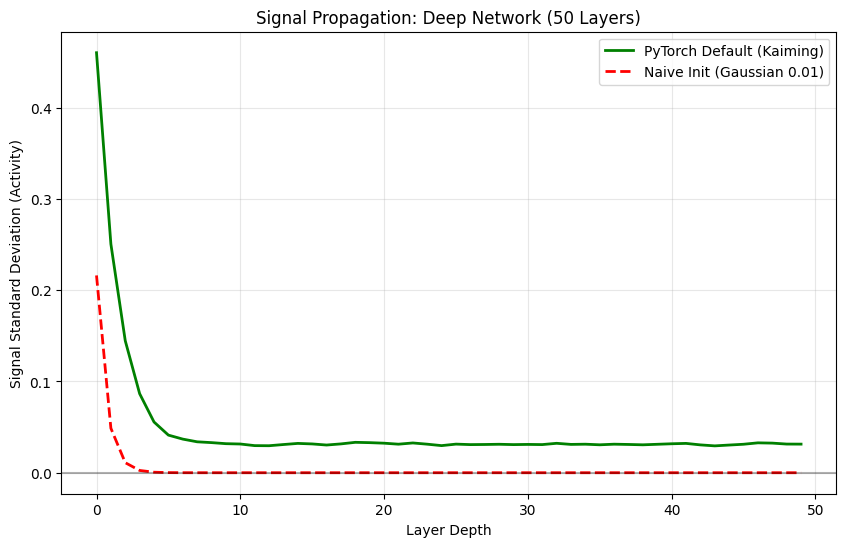

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def visualize_signal_propagation(init_method="default"):
    # 1. Setup
    depth = 50
    dim = 512
    num_samples = 1000
    
    # Input: Healthy Standard Normal Data
    x = torch.randn(num_samples, dim)
    
    # 2. The Network
    layers = []
    for _ in range(depth):
        layer = nn.Linear(dim, dim)
        
        # --- THE SABOTAGE STEP ---
        if init_method == "naive":
            # This is how we used to initialize weights before ~2015
            # Small random numbers. It looks innocent, but it kills deep networks.
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            nn.init.zeros_(layer.bias)
            
        layers.append(layer)
        layers.append(nn.Tanh())
    
    model = nn.Sequential(*layers)
    
    # 3. Forward Pass & Logging
    stds = []
    layer_indices = []
    
    current_x = x
    with torch.no_grad():
        for i, layer in enumerate(model):
            current_x = layer(current_x)
            
            # Only log after the activation function (every 2nd item)
            if isinstance(layer, nn.Tanh):
                # Calculate Std of the signal at this depth
                std = current_x.std().item()
                stds.append(std)
                layer_indices.append(i // 2) # Layer number (0 to 50)

    return layer_indices, stds

# 4. Run Experiment & Plot
plt.figure(figsize=(10, 6))

# Run 1: Default PyTorch Init (Kaiming/Smart)
indices_smart, stds_smart = visualize_signal_propagation(init_method="default")
plt.plot(indices_smart, stds_smart, label="PyTorch Default (Kaiming)", color="green", linewidth=2)

# Run 2: Naive Init (The "Pre-Norm" Problem)
indices_naive, stds_naive = visualize_signal_propagation(init_method="naive")
plt.plot(indices_naive, stds_naive, label="Naive Init (Gaussian 0.01)", color="red", linestyle="--", linewidth=2)

plt.title("Signal Propagation: Deep Network (50 Layers)")
plt.xlabel("Layer Depth")
plt.ylabel("Signal Standard Deviation (Activity)")
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The deeper layers (Layer 40+) are receiving inputs that are basically all zeros.

If the input is zero, the gradient calculation during backpropagation will also be zero.

Result: The network stops learning. The weights never update. The model is "dead."

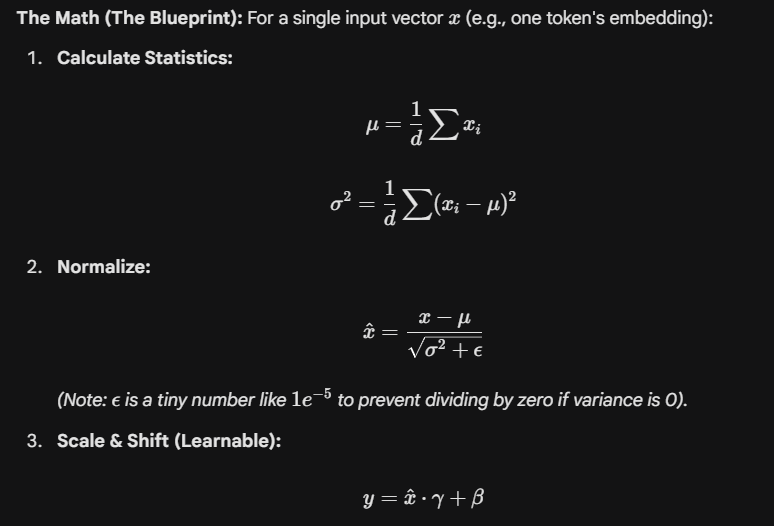


In [3]:
class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        
        # 1. The Parameters (The "Knobs")
        # Gamma (Scale): Initialize to 1 (don't scale initially)
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        
        # Beta (Shift): Initialize to 0 (don't shift initially)
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
        
        self.eps = eps

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Dim) 
        # We want stats across the LAST dimension (Dim)
        
        # 1. Calculate Mean
        # keepdim=True is crucial! 
        # Turns (32, 10, 512) -> (32, 10, 1) so we can broadcast subtraction
        mean = x.mean(dim=-1, keepdim=True)
        
        # 2. Calculate Variance
        # Var = Mean of (x - mean)^2
        var = ((x - mean) ** 2).mean(dim=-1, keepdim=True)
        
        # 3. Normalize
        # Add eps before sqrt for stability
        std = torch.sqrt(var + self.eps)
        x_norm = (x - mean) / std
        
        # 4. Scale and Shift (The Learnable Part)
        # Gamma and Beta broadcast automatically
        y = x_norm * self.gamma + self.beta
        
        return y

# --- VERIFICATION LAB ---
def test_implementation():
    print("--- Verifying MyLayerNorm vs nn.LayerNorm ---")
    
    # 1. Setup Data
    B, T, C = 2, 5, 4  # Batch, Time, Channels
    x = torch.randn(B, T, C)
    
    # 2. Initialize Both Layers
    my_ln = MyLayerNorm(C)
    torch_ln = nn.LayerNorm(C)
    
    # Force them to have identical weights for comparison
    # (By default they are 1 and 0 anyway, but good practice)
    with torch.no_grad():
        my_ln.gamma.copy_(torch_ln.weight)
        my_ln.beta.copy_(torch_ln.bias)

    # 3. Run Forward Pass
    y_mine = my_ln(x)
    y_torch = torch_ln(x)
    
    # 4. Compare
    # Check if they are close (within 0.000001)
    diff = (y_mine - y_torch).abs().max().item()
    
    print(f"Max Difference: {diff:.8f}")
    if diff < 1e-5:
        print("✅ SUCCESS: Your implementation matches PyTorch exactly.")
    else:
        print("❌ FAILURE: Implementations diverge.")

if __name__ == "__main__":
    test_implementation()

--- Verifying MyLayerNorm vs nn.LayerNorm ---
Max Difference: 0.00000036
✅ SUCCESS: Your implementation matches PyTorch exactly.


## RMSNorm (Root Mean Square Norm)

Think back to LayerNorm. It does two things:

1. **Re-centering:** Subtracts the mean ($\mu$) to shift the graph to 0.
2. **Re-scaling:** Divides by variance ($\sigma$) to shrink/expand the graph.

### The Discovery (2019)

Researchers found that **re-centering is expensive and unnecessary**:

- Calculating the mean requires summing the whole vector
- Subtracting it requires another pass
- It turns out, the "re-scaling" part is what actually keeps the gradients stable

### RMSNorm Strategy

- Don't calculate the mean. Don't subtract it.
- Just calculate the magnitude (Root Mean Square) and divide by it.

**Result:** Faster calculation, same stability.

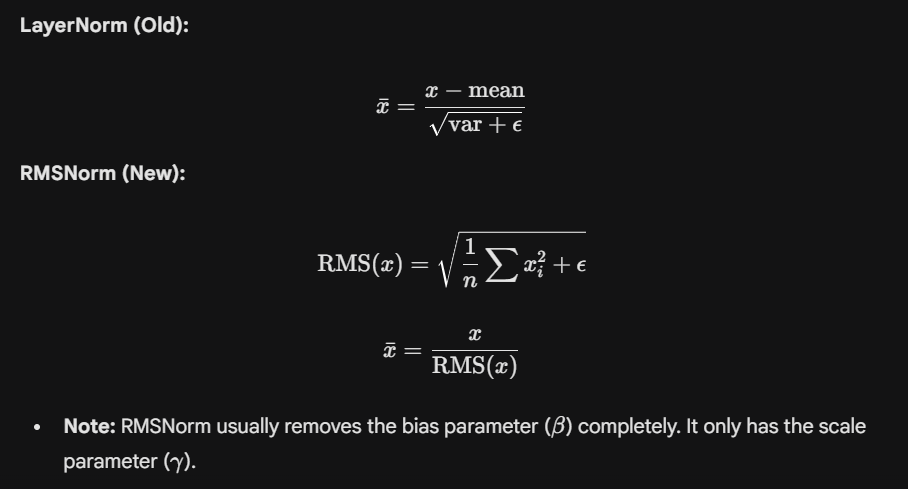

In [4]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        
        # The Scale Parameter (Gamma)
        # Note: No Beta (Shift) parameter in standard RMSNorm!
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        # 1. Calculate RMS
        # mean(x^2) -> square root
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # 2. Normalize and Scale
        # Usually we convert to float32 for the norm calc to avoid overflow/underflow
        output = self._norm(x.float()).type_as(x)
        
        return output * self.weight

# --- VERIFICATION LAB ---
def compare_norms():
    x = torch.randn(2, 5, 4) # Batch, Seq, Dim
    
    ln = nn.LayerNorm(4)
    rms = RMSNorm(4)
    
    print(f"Input: {x[0,0].tolist()}")
    print(f"LayerNorm: {ln(x)[0,0].tolist()}")
    print(f"RMSNorm:   {rms(x)[0,0].tolist()}")
    
    # Notice: RMSNorm values are slightly different because they aren't centered at 0
    # But they are still bounded and stable!

if __name__ == "__main__":
    compare_norms()

Input: [0.7632403373718262, -0.13564756512641907, -0.8962355256080627, 0.7258767485618591]
LayerNorm: [0.9468551874160767, -0.36471036076545715, -1.474482774734497, 0.8923380374908447]
RMSNorm:   [1.09847891330719, -0.19522814452648163, -1.2898896932601929, 1.0447040796279907]


## decision (Pre-Norm vs Post-Norm) is what allowed GPT-3 to scale while BERT struggled.

## The Golden Rule: The "Residual Connection"

In deep learning, we want to preserve the original information. We do this by adding the input to the output:

**"New Value = Old Value + Change"**

This `+` is the **"Residual Connection."** It is the most important part.

### Post-Norm (The "Blocked Road")

This was the original design (BERT).

**The Flow:**

1. **Input ($x$):** You start with data.
2. **Side Mission:** You process the data (Attention/FFN).
3. **Add:** You add the result to the original input.
4. **Normalize EVERYTHING:** You take this huge combined sum and force it through normalization.


Why this is bad (The Blockage): Imagine the "Main Road" is the signal traveling from Layer 1 to Layer 100. In Post-Norm, the Main Road goes through the Normalization station at every single block.

**The signal gets "squashed" and reshaped 100 times.**

When the network tries to learn (Backpropagation), the error signal has to fight its way backward through 100 normalization stations. It gets weak and distorted.

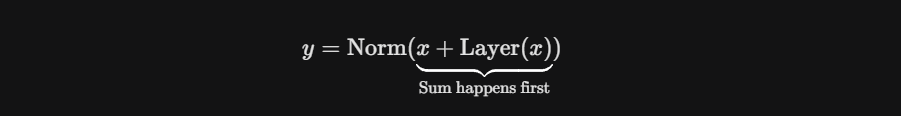

### Pre-Norm (The "Clean Highway")

This is the modern design (GPT/Llama).

**The Flow:**

1. **Input ($x$):** You start with data.
2. **Side Mission Starts:** You make a copy of $x$.
3. **Normalize the COPY:** You normalize just the copy. The original $x$ is untouched.
4. **Process the COPY:** You send the normalized copy to the layer (Attention/FFN).
5. **Add:** You add this result back to the original, untouched $x$.

**The Equation:**

$$y = \underbrace{x}_{\text{Untouched}} + \text{Layer}(\text{Norm}(x))$$

**Why this is good (The Highway):**

Look at the standalone $x$ in the equation. The "Main Road" travels entirely outside the normalization:

- Layer 1 adds a bit of info.
- Layer 2 adds a bit of info.
- Layer 100 adds a bit of info.

The original signal flows straight through from start to finish without ever being "squashed" by the Norm.

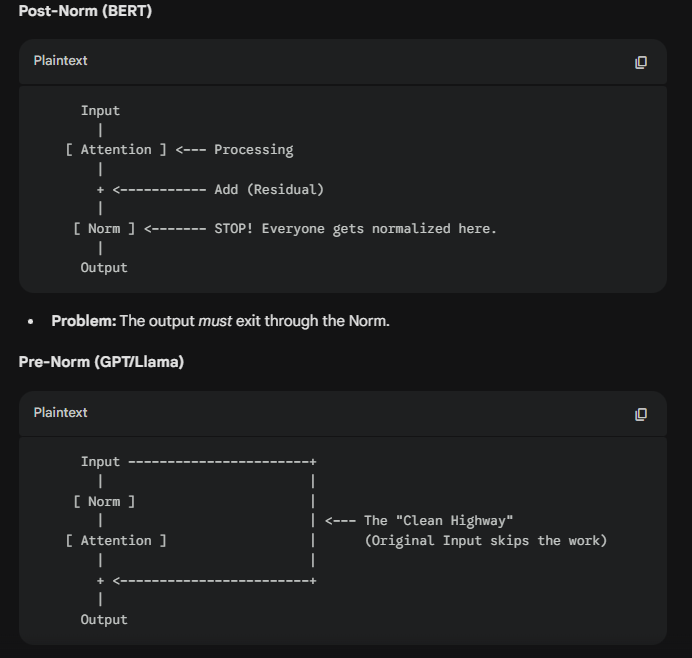

## The Gradient Flow Experiment

**The Objective:** Train two identical deep networks (20 layers).

- **Network A (Post-Norm):** The "Blocked Road."
- **Network B (Pre-Norm):** The "Clean Highway."

We will measure the **Gradient Norm** at the very first layer (Layer 0).

- If the gradient is small/zero, the signal died on the way back (**Vanishing Gradient**).
- If the gradient is stable, the Highway works.

Depth      | Post-Norm       | Pre-Norm       
---------------------------------------------
2          | 1.584768        | 2.015289
4          | 1.756063        | 2.573937
6          | 1.679793        | 2.461431
8          | 1.991601        | 3.155277
10         | 1.836435        | 3.326999
15         | 1.574457        | 2.916023
20         | 1.718591        | 4.184085


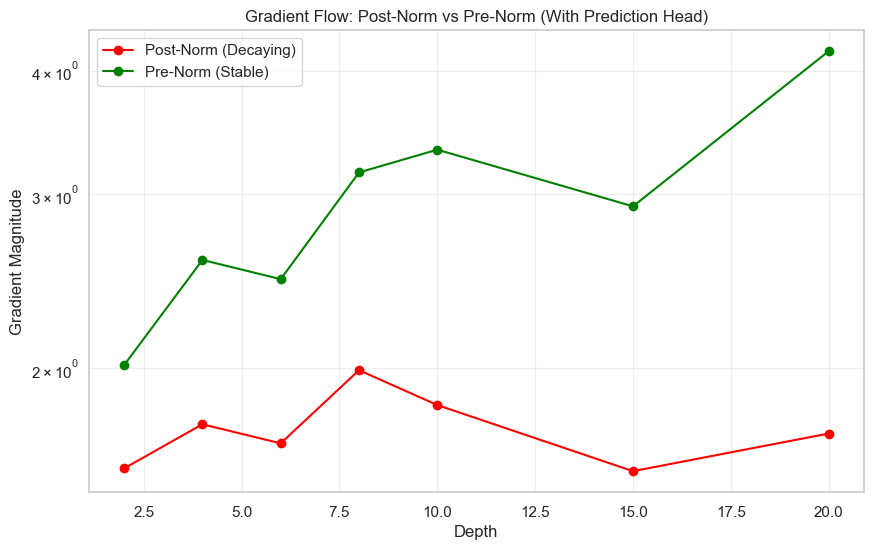

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- 1. The Architectures (Now with a Prediction Head) ---
class PostNormNetwork(nn.Module):
    def __init__(self, depth, dim):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'norm': nn.LayerNorm(dim),
                'linear': nn.Linear(dim, dim),
                'act': nn.Tanh() 
            }) for _ in range(depth)
        ])
        # THE FIX: A final "Head" to produce a real score
        self.head = nn.Linear(dim, 1) 
    
    def forward(self, x):
        for layer in self.layers:
            # Post-Norm Block
            out = layer['linear'](x)
            out = layer['act'](out)
            x = layer['norm'](x + out) 
        return self.head(x) # Return un-normalized score

class PreNormNetwork(nn.Module):
    def __init__(self, depth, dim):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'norm': nn.LayerNorm(dim),
                'linear': nn.Linear(dim, dim),
                'act': nn.Tanh()
            }) for _ in range(depth)
        ])
        # THE FIX: A final "Head"
        self.head = nn.Linear(dim, 1)
    
    def forward(self, x):
        for layer in self.layers:
            # Pre-Norm Block
            x_norm = layer['norm'](x)
            out = layer['linear'](x_norm)
            out = layer['act'](out)
            x = x + out 
        return self.head(x)

# --- 2. The Experiment ---
def run_gradient_experiment():
    # We start with very shallow depths to capture the decay curve
    depths = [2, 4, 6, 8, 10, 15, 20]
    dim = 256
    
    post_grads = []
    pre_grads = []
    
    print(f"{'Depth':<10} | {'Post-Norm':<15} | {'Pre-Norm':<15}")
    print("-" * 45)

    for d in depths:
        # 1. Post-Norm Run
        model = PostNormNetwork(d, dim)
        x = torch.randn(16, dim)
        
        # Loss is now based on the prediction head output
        loss = model(x).mean() 
        
        model.zero_grad()
        loss.backward()
        
        # Check gradient at the FIRST linear layer (closest to input)
        g_post = model.layers[0]['linear'].weight.grad.norm().item()
        post_grads.append(g_post)

        # 2. Pre-Norm Run
        model = PreNormNetwork(d, dim)
        x = torch.randn(16, dim)
        loss = model(x).mean()
        model.zero_grad()
        loss.backward()
        g_pre = model.layers[0]['linear'].weight.grad.norm().item()
        pre_grads.append(g_pre)
        
        print(f"{d:<10} | {g_post:.6f}        | {g_pre:.6f}")

    # --- 3. Plotting ---
    plt.figure(figsize=(10, 6))
    plt.plot(depths, post_grads, 'o-', label='Post-Norm (Decaying)', color='red')
    plt.plot(depths, pre_grads, 'o-', label='Pre-Norm (Stable)', color='green')
    plt.title('Gradient Flow: Post-Norm vs Pre-Norm (With Prediction Head)')
    plt.xlabel('Depth')
    plt.ylabel('Gradient Magnitude')
    plt.yscale('log') # Log scale helps see the decay
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

if __name__ == "__main__":
    torch.manual_seed(42) # Ensure consistent results
    run_gradient_experiment()